<a href="https://colab.research.google.com/github/springboardmentor2501/Shipment-Sure/blob/Almeehra-Shaikh/milestone3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original shape: (1000, 16)
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Number of positive: 270, number of negative: 280
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2737
[LightGBM] [Info] Number of data points in the train set: 550, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.490909 -> initscore=-0.036368
[LightGBM] [Info] Start training from score -0.036368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

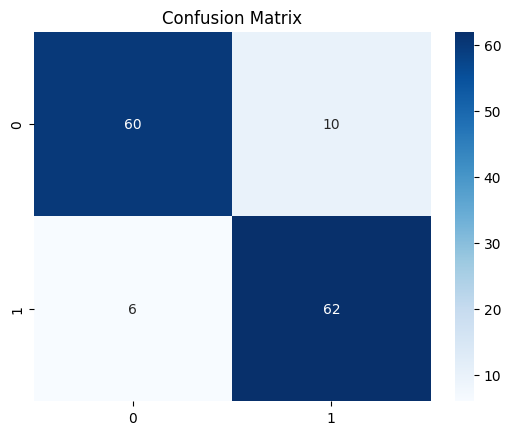

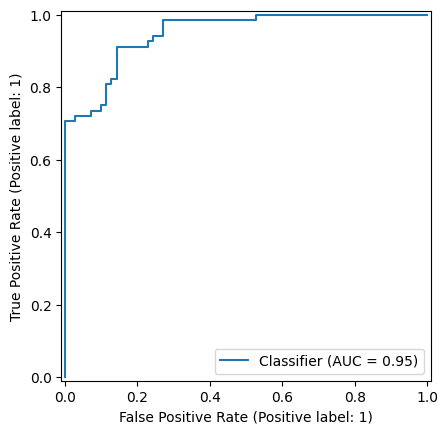

['shipment_delay_model.pkl']

In [3]:
# ------------------------------------------------------------
# 1. Imports
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score,
    classification_report, RocCurveDisplay
)

from imblearn.pipeline import Pipeline as ImbPipeline
import lightgbm as lgb
import joblib, warnings
warnings.filterwarnings("ignore")

# ------------------------------------------------------------
# 2. Load data
# ------------------------------------------------------------
PATH = "/content/smart_logistics_dataset.csv"
df = pd.read_csv(PATH, parse_dates=["Timestamp"])
print("Original shape:", df.shape)

# ------------------------------------------------------------
# 3. Target creation & filtering
# ------------------------------------------------------------
df = df[df.Shipment_Status.isin(["Delivered", "Delayed"])]

target_map = {"Delivered": 1, "Delayed": 0}
df["Target"] = df.Shipment_Status.map(target_map)
y = df["Target"]

# ------------------------------------------------------------
# 4. Time-based features (cyclical)
# ------------------------------------------------------------
df["month"]   = df.Timestamp.dt.month
df["day"]     = df.Timestamp.dt.day
df["weekday"] = df.Timestamp.dt.weekday
df["hour"]    = df.Timestamp.dt.hour

def add_cyclical(df, col, max_val):
    df[f"{col}_sin"] = np.sin(2 * np.pi * df[col] / max_val)
    df[f"{col}_cos"] = np.cos(2 * np.pi * df[col] / max_val)

for col, maxv in [("month",12), ("day",31), ("weekday",7), ("hour",24)]:
    add_cyclical(df, col, maxv)

# ------------------------------------------------------------
# 5. Asset reliability encoding (VERY IMPORTANT)
# ------------------------------------------------------------
asset_delay_rate = df.groupby("Asset_ID")["Target"].mean()
df["asset_delay_rate"] = df["Asset_ID"].map(asset_delay_rate)

# ------------------------------------------------------------
# 6. Risk & environmental features
# ------------------------------------------------------------
df["risk_high_traffic"] = (df.Traffic_Status.isin(["Heavy", "Detour"])).astype(int)
df["risk_delay_reason"] = df.Logistics_Delay_Reason.notna().astype(int)

# Continuous deviations (better than binary flags)
df["temp_deviation"] = np.abs(df.Temperature - 22)
df["humidity_deviation"] = np.abs(df.Humidity - 60)

# ------------------------------------------------------------
# 7. Traffic ordinal severity
# ------------------------------------------------------------
traffic_map = {"Clear": 0, "Heavy": 1, "Detour": 2}
df["traffic_severity"] = df.Traffic_Status.map(traffic_map)

# ------------------------------------------------------------
# 8. Geo features
# ------------------------------------------------------------
df["abs_lat"] = df.Latitude.abs()
df["abs_long"] = df.Longitude.abs()
df["geo_distance_proxy"] = np.sqrt(df.Latitude**2 + df.Longitude**2)

# ------------------------------------------------------------
# 9. Interaction features
# ------------------------------------------------------------
df["util_demand"] = df.Asset_Utilization * df.Demand_Forecast
df["inv_wait"] = df.Inventory_Level * df.Waiting_Time
df["wait_per_traffic"] = df.Waiting_Time * df["risk_high_traffic"]

# ------------------------------------------------------------
# 10. Customer importance signal
# ------------------------------------------------------------
df["high_value_customer"] = (
    (df.User_Transaction_Amount > df.User_Transaction_Amount.quantile(0.75)) &
    (df.User_Purchase_Frequency > df.User_Purchase_Frequency.quantile(0.75))
).astype(int)

# ------------------------------------------------------------
# 11. Handle potential leakage
# ------------------------------------------------------------
df["has_delay_record"] = (df.Logistics_Delay > 0).astype(int)
df.drop(columns=["Logistics_Delay"], inplace=True)

# ------------------------------------------------------------
# 12. Feature selection
# ------------------------------------------------------------
drop_cols = ["Timestamp", "Shipment_Status", "Asset_ID", "Target"]
X = df.drop(columns=drop_cols)

num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = ["Traffic_Status", "Logistics_Delay_Reason"]

# ------------------------------------------------------------
# 13. Preprocessing
# ------------------------------------------------------------
numeric_pipe = Pipeline([
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

# ------------------------------------------------------------
# 14. Train-test split
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ------------------------------------------------------------
# 15. LightGBM model (NO SMOTE – better for F1 here)
# ------------------------------------------------------------
scale_pos = y_train.value_counts()[0] / y_train.value_counts()[1]

lgbm = lgb.LGBMClassifier(
    objective="binary",
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=40,
    scale_pos_weight=scale_pos,
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", lgbm)
])

# ------------------------------------------------------------
# 16. GridSearch (F1 optimized)
# ------------------------------------------------------------
param_grid = {
    "clf__max_depth": [6, 7],
    "clf__num_leaves": [31, 40],
    "clf__learning_rate": [0.05, 0.1]
}

grid = GridSearchCV(
    pipe,
    param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("Best CV F1:", grid.best_score_)
print("Best Params:", grid.best_params_)

# ------------------------------------------------------------
# 17. Threshold tuning for MAX F1
# ------------------------------------------------------------
y_prob = best_model.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.3, 0.7, 100)
best_f1, best_t = 0, 0.5

for t in thresholds:
    preds = (y_prob >= t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1, best_t = f1, t

y_pred = (y_prob >= best_t).astype(int)

# ------------------------------------------------------------
# 18. Final evaluation
# ------------------------------------------------------------
print("\n========== FINAL HOLD-OUT RESULTS ==========")
print("Best Threshold:", round(best_t, 3))
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-Score :", f1_score(y_test, y_pred))
print("ROC-AUC  :", roc_auc_score(y_test, y_prob))
print("\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_prob)
plt.show()

# ------------------------------------------------------------
# 19. Save model
# ------------------------------------------------------------
joblib.dump(best_model, "shipment_delay_model.pkl")
